In [95]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

Source for our data: https://fred.stlouisfed.org/series/GASREGW

In [99]:
data = pd.read_csv(r'/Users/ayushnigade/Documents/Brent Oil Prediction/New Version/GASREGW.csv')
data

,DATE,GASREGW
0,1990-08-20,1.191
1,1990-08-27,1.245
2,1990-09-03,1.242
3,1990-09-10,1.252
4,1990-09-17,1.266
...,...,...
1771,2024-07-29,3.484
1772,2024-08-05,3.448
1773,2024-08-12,3.414
1774,2024-08-19,3.382


### Data Cleaning

In [71]:
data['DATE'] = pd.to_datetime(data['DATE'])

In [72]:
# check for nulls on all columns
null_mask = data.isnull().any(axis=1)
null_rows = data[null_mask]
null_rows

,DATE,GASREGW


In [73]:
data[data['GASREGW']=='.']

,DATE,GASREGW
16,1990-12-10,.
17,1990-12-17,.
18,1990-12-24,.
19,1990-12-31,.
20,1991-01-07,.
21,1991-01-14,.


In [74]:
# impute the missing values by calculating the linear guess using the two adjacent points
data['GASREGW'] = data['GASREGW'].replace('.', np.nan)
data['GASREGW'] = pd.to_numeric(data['GASREGW'], errors='coerce')
data['GASREGW'] = data['GASREGW'].interpolate(method='linear')
data['GASREGW']

0       1.191
1       1.245
2       1.242
3       1.252
4       1.266
        ...  
1771    3.484
1772    3.448
1773    3.414
1774    3.382
1775    3.313
Name: GASREGW, Length: 1776, dtype: float64

### Is this stationary?
We can visually see no, but we will do some further tests in a bit just for being rigorous.

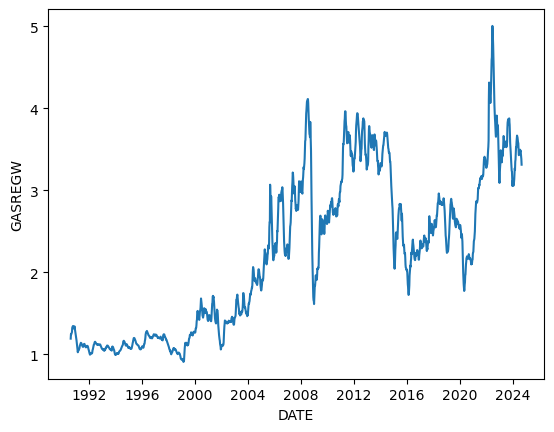

<Figure size 640x480 with 0 Axes>

In [75]:
sns.lineplot(data=data, x='DATE', y='GASREGW')
# Customize tick marks shows every 200th tick on x and y axis
#plt.xticks(ticks=range(0, 1776, 200), rotation=90)  
#plt.yticks(ticks=range(0, 1776, 200))


plt.show()
plt.clf()
 

### A more rigorous check for stationarity

With weak stationarity the mean and variance should not be dependant on time. So we will calculate the mean and variance of different chunks of the data to see if this data is stationary. 

In [76]:
df_split = np.array_split(data, 10)
df_split

for i in range(10):
    print("Data Split", str(i+1) + ":", "Mean:", np.mean(df_split[i]['GASREGW']), "Variance:", np.var(df_split[i]['GASREGW']))

Data Split 1: Mean: 1.1082696629213482 Variance: 0.006301822948040471
Data Split 2: Mean: 1.141123595505618 Variance: 0.005499119555611667
Data Split 3: Mean: 1.201623595505618 Variance: 0.037662414499431904
Data Split 4: Mean: 1.4607022471910112 Variance: 0.02576857988259058
Data Split 5: Mean: 2.3772808988764043 Variance: 0.16117294356773143
Data Split 6: Mean: 2.815033707865169 Variance: 0.3090254820098472
Data Split 7: Mean: 3.559740112994351 Variance: 0.03800423754349006
Data Split 8: Mean: 2.4547457627118643 Variance: 0.16788242688882513
Data Split 9: Mean: 2.505395480225989 Variance: 0.08315390009256603
Data Split 10: Mean: 3.546751412429378 Variance: 0.18184120374094284


We can see the mean and variance change over time in the above output. Illustrating that our the time series is currently not stationary. We can do an even 
more rigorous test to further affirm that the time series is not stationary. This can be done using the Augmented Dickey-Fuller Test and the code for that is below.

In [77]:
output = adfuller(data['GASREGW'])
output

(-1.5426155765988994,
 0.5123346645158965,
 25,
 1750,
 {'1%': -3.4340922388213175,
  '5%': -2.863192990001633,
  '10%': -2.5676500029387754},
 -6202.391416927288)

So from the above output we can see the Test statistic is -1.5426155765988994 which is greater than the critical value (-2.863192990001633) at the 5% significance level. We can also see that the p-value 0.5123346645158965 is greater than the significance level of 5%. Thus, we fail to reject the null hypothesis.

The null hypothesis is that the data are non-stationary. 

### Detrending our data
We will have to detrend our data because we have shown above that our data is non-stationary. We will first try a first order differencing.

In [78]:
data

,DATE,GASREGW
0,1990-08-20,1.191
1,1990-08-27,1.245
2,1990-09-03,1.242
3,1990-09-10,1.252
4,1990-09-17,1.266
...,...,...
1771,2024-07-29,3.484
1772,2024-08-05,3.448
1773,2024-08-12,3.414
1774,2024-08-19,3.382


<Axes: xlabel='DATE', ylabel='Diff_1_Price'>

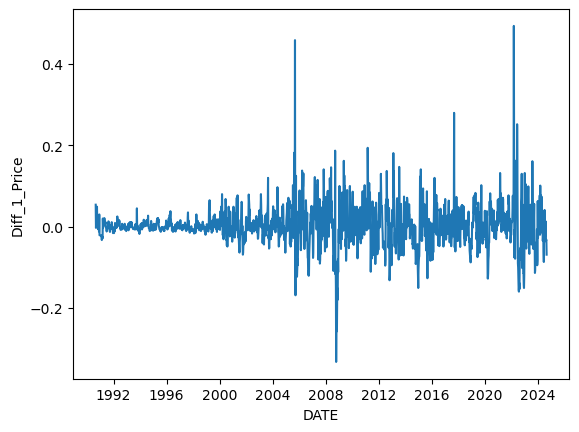

In [79]:
data['Diff_1_Price'] = data['GASREGW'].diff()
sns.lineplot(data=data, x='DATE', y='Diff_1_Price')

In [81]:
# We start from the second index of the series because the first value will be NaN because the data is a difference
output = adfuller(data['Diff_1_Price'][1:])
output

(-10.638701993046439,
 4.994352781162867e-19,
 24,
 1750,
 {'1%': -3.4340922388213175,
  '5%': -2.863192990001633,
  '10%': -2.5676500029387754},
 -6197.422218452704)

From the above Augmented Dickey Fuller test we can see that the time series after doing first order differencing is stationary. This is because the test statistic -10.638701993046439 is lower than the critical value -2.863192990001633 at the 5% significance level. We also see the p-value to be lower than the significance level of 5%. As a result, we can reject the null hypothesis.

Let us try to see if there is seasonality from our stationary time series

<Axes: xlabel='DATE', ylabel='Diff_1_Price'>

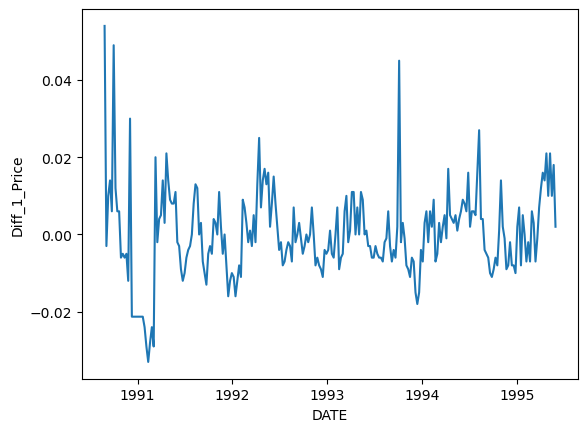

In [84]:
sns.lineplot(data=data[1:250], x='DATE', y='Diff_1_Price')

We cannot easily distinguish visually whether there is any seasonality from the above graph. However, that does not mean there is no seasonality. We will proceed to graph the PACF and ACF and take next steps from there.

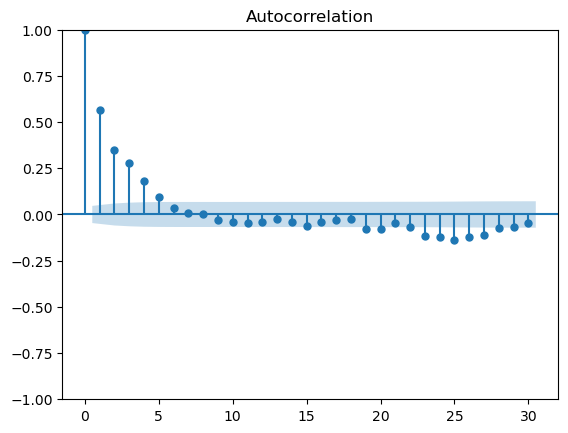

In [90]:
plot_acf(data['Diff_1_Price'][1:], lags=30); # need semicolon otherwise it gets plotted twice

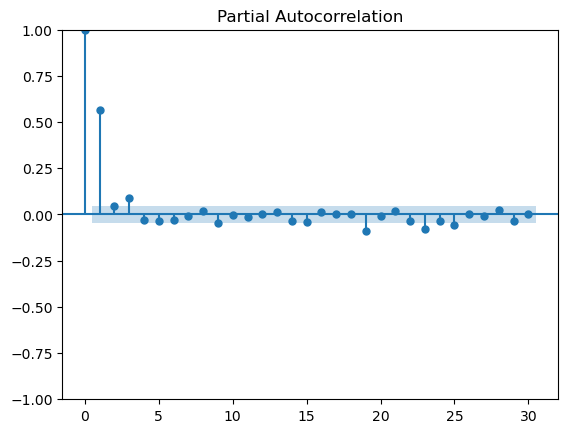

In [91]:
plot_pacf(data['Diff_1_Price'][1:], lags=30);

We do not see significant seasonal trends that would require seasonal differencing and if any we could integrate it into the the model fit for the ARIMA model. We are next going to use the above graphs and other statistics to ascertain the best model fit.

                               SARIMAX Results                                
Dep. Variable:           Diff_1_Price   No. Observations:                 1775
Model:                 ARIMA(1, 0, 5)   Log Likelihood                3156.749
Date:                Fri, 06 Sep 2024   AIC                          -6297.498
Time:                        18:08:19   BIC                          -6253.645
Sample:                             0   HQIC                         -6281.299
                               - 1775                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.003      0.440      0.660      -0.004       0.007
ar.L1          0.5059      0.158      3.208      0.001       0.197       0.815
ma.L1          0.0327      0.158      0.207      0.8

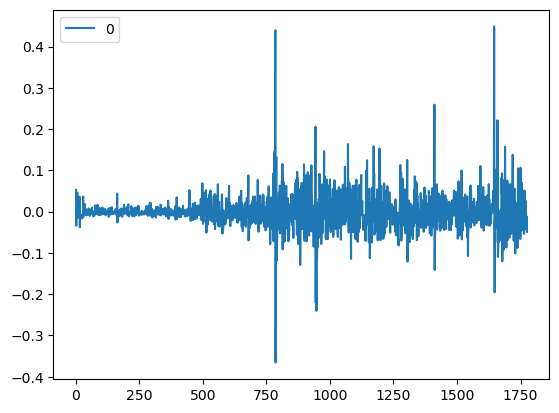

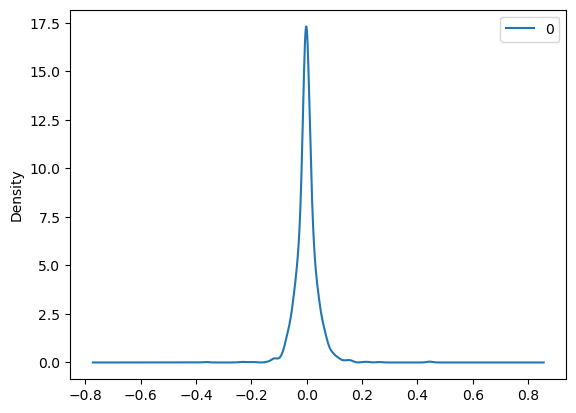

                 0
count  1775.000000
mean     -0.000025
std       0.040882
min      -0.365552
25%      -0.016102
50%      -0.001535
75%       0.014444
max       0.448910


In [98]:
# fit model
model = ARIMA(data['Diff_1_Price'][1:], order=(1,0,5))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

Next steps to do:...figure out if the fit for the ARMA model is actually any good. Also look into the heteroscadicity. Heteroscadicity: when standard deviation changes with respect to time